**Importing and preparation**

In [1]:
import td3
import test_utils
import core
import numpy as np
import torch

/Users/fengyyuan/anaconda3/envs/diffusion_mv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_assets = 10
fea_dim = 10

time_horizon = 13
Test_time_horizon = 121
test_frequency = 12
risk_aversion = 1.5
num_test_episodes = 100
seed = 2025
obs_dim = fea_dim + 2
act_dim = num_assets
algo_list = ['TD3', 'EW', 'Markowitz']
type_list = ['Return', 'Sharpe', 'MV']


torch.manual_seed(seed)
np.random.seed(seed)


simulate_mean = np.array([0.15, 0.12, 0.18, 0.14, 0.25, 0.10, 0.08, 0.09, 0.07, 0.11])/12

simulate_cov = np.array([
    [0.1024, 0.0627, 0.1008, 0.0672, 0.1568, 0.0320, 0.0230, 0.0256, 0.0448, 0.0282],
    [0.0627, 0.0784, 0.0882, 0.0588, 0.1372, 0.0280, 0.0202, 0.0224, 0.0392, 0.0246],
    [0.1008, 0.0882, 0.2025, 0.0945, 0.2205, 0.0450, 0.0324, 0.0360, 0.0630, 0.0396],
    [0.0672, 0.0588, 0.0945, 0.0900, 0.1470, 0.0300, 0.0216, 0.0240, 0.0420, 0.0264],
    [0.1568, 0.1372, 0.2205, 0.1470, 0.4900, 0.0700, 0.0504, 0.0560, 0.0980, 0.0616],
    [0.0320, 0.0280, 0.0450, 0.0300, 0.0700, 0.0625, 0.0135, 0.0150, 0.0350, 0.0330],
    [0.0230, 0.0202, 0.0324, 0.0216, 0.0504, 0.0135, 0.0324, 0.0288, 0.0252, 0.0119],
    [0.0256, 0.0224, 0.0360, 0.0240, 0.0560, 0.0150, 0.0288, 0.0400, 0.0280, 0.0132],
    [0.0448, 0.0392, 0.0630, 0.0420, 0.0980, 0.0350, 0.0252, 0.0280, 0.1225, 0.0231],
    [0.0282, 0.0246, 0.0396, 0.0264, 0.0616, 0.0330, 0.0119, 0.0132, 0.0231, 0.0484]
])/12


# Set the test scenario
test_generator = core.ScenarioGenerator(num_assets, fea_dim, Test_time_horizon, num_test_episodes, 'simulate', simulate_mean, simulate_cov, None, mode = 'testing')
test_scenario = test_generator.get_data()

**Training**

In [3]:
ac, epoch_list = td3.td3(num_assets, fea_dim, time_horizon, Test_time_horizon, None, simulate_mean, simulate_cov,seed=seed, 
         steps_per_epoch=50, epochs=200,polyak=0.99, pi_lr=1e-3, q_lr=1e-3, batch_size=16, start_steps=200, 
         update_after=50, update_every=50, policy_delay = 2)

Logging data to /tmp/experiments/1745413717/progress.txt

Number of parameters: 	 pi: 18122, 	 q1: 18177, 	 q2: 18177



/opt/anaconda3/envs/diffusion_mv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Checkpoint saved to checkpoints/td3_ep5.pth
-------------------------------------
|          LossPi |            7.19 |
|           LossQ |             101 |
|            Time |            6.66 |
-------------------------------------
Step 249: pi_lr=0.000998, q_lr=0.000998
Checkpoint saved to checkpoints/td3_ep6.pth
-------------------------------------
|          LossPi |            12.2 |
|           LossQ |             108 |
|            Time |            8.35 |
-------------------------------------
Step 299: pi_lr=0.000998, q_lr=0.000998
Checkpoint saved to checkpoints/td3_ep7.pth
-------------------------------------
|          LossPi |            13.9 |
|           LossQ |             107 |
|            Time |            9.98 |
-------------------------------------
Step 349: pi_lr=0.000997, q_lr=0.000997
Checkpoint saved to checkpoints/td3_ep8.pth
-------------------------------------
|          LossPi |            15.4 |
|           LossQ |            99.3 |
|            Time | 

**Prepare the Baseline**

In [3]:
markowitz_action = test_utils.solve_markowitz(simulate_mean*12, simulate_cov*12, risk_aversion,num_assets)
print(f"Markowitz Action: {markowitz_action}")

#Bulding the test baselines
EW_return_list, EW_volatility_list, EW_sharpe_list, EW_mv, _ = test_utils.test_agent_equal_weight(test_scenario, Test_time_horizon, num_test_episodes, num_assets, risk_aversion, test_frequency)
MK_return_list, MK_volatility_list, MK_sharpe_list, MK_mv, _ = test_utils.test_agent_static(test_scenario, Test_time_horizon, num_test_episodes, num_assets, risk_aversion, test_frequency,markowitz_action)

Markowitz Action: [ 2.41981546e-01 -3.58806081e-23  7.47108465e-02  1.59539307e-01
  4.86129970e-02 -6.33029036e-23 -6.88006257e-23  7.97640573e-02
 -1.99232861e-23  3.95391247e-01]


**Present Training log**

Markowitz Action: [ 2.41981546e-01 -6.58308249e-24  7.47108465e-02  1.59539307e-01
  4.86129970e-02 -1.02601032e-22  2.64328162e-23  7.97640573e-02
 -6.48245916e-23  3.95391247e-01]
Test Baselines
EW-Return(sd)   12.96 % ( 0.08)
EW-Volatility(sd)   0.25 ( 0.07)
EW-Sharpe(sd)   0.51 ( 0.31)
EW-MV   0.07
MK-Return(sd)   13.92 % ( 0.08)
MK-Volatility(sd)   0.24 ( 0.07)
MK-Sharpe(sd)   0.57 ( 0.32)
MK-MV   0.09
Checkpoint loaded from checkpoints/td3_ep5.pth (episode 5)
The final output action: [0.10459703 0.1892347  0.0952225  0.0818297  0.12254536 0.00449956
 0.13807966 0.1048037  0.05081049 0.10837732]
Final wealth:1.4649468660354614, Test Multiplier: 16.999977111816406
Shape of feature: torch.Size([121, 1, 10])
mv_list: [0.10999228 0.01969883 0.10883615 0.06515382 0.06368511 0.07092931
 0.10985163 0.01921649 0.14705578 0.05134769]
Checkpoint loaded from checkpoints/td3_ep6.pth (episode 6)
The final output action: [0.1383824  0.18364543 0.08730888 0.07586579 0.11979062 0.00557562
 0.0846

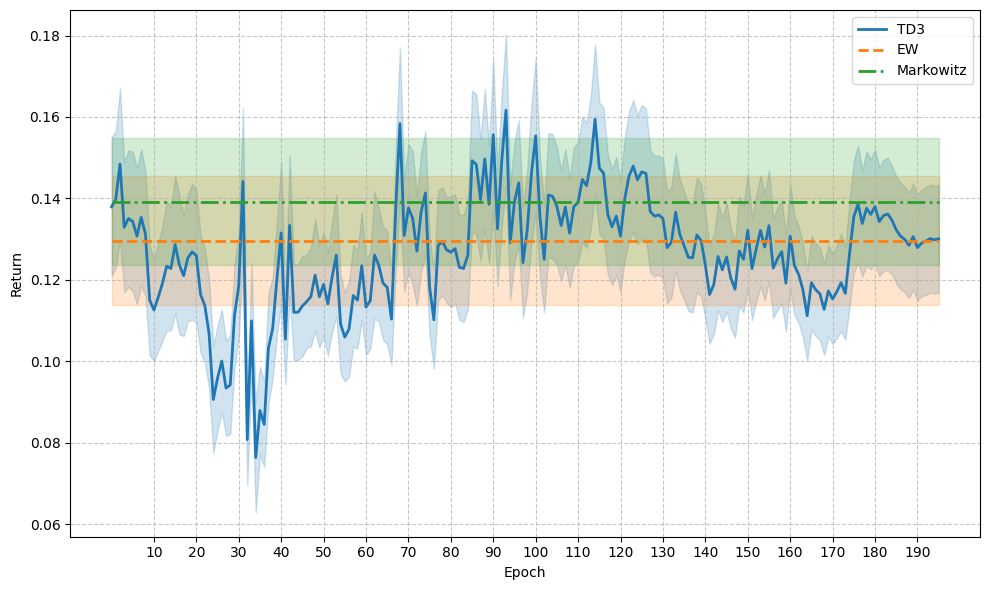

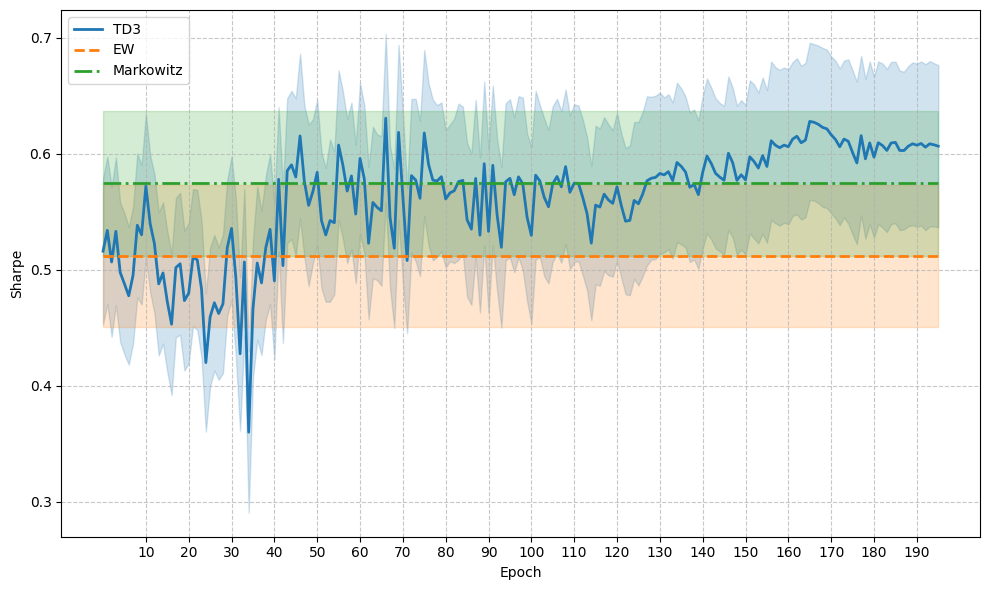

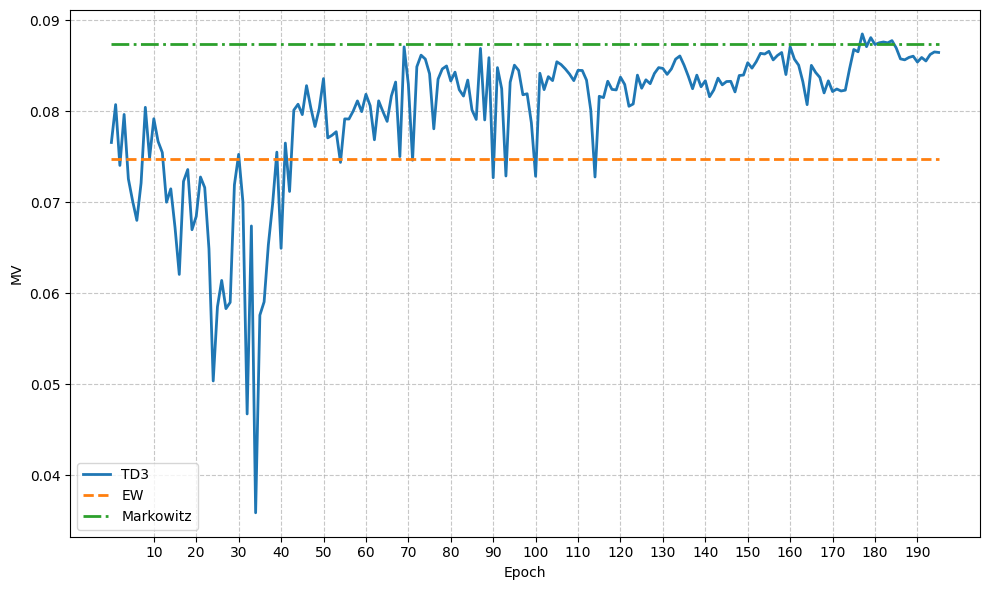

In [ ]:



print("Test Baselines")
print('EW-Return(sd)', f' {EW_return_list.mean()*100: .2f} % ({EW_return_list.std(): .2f})' )
print('EW-Volatility(sd)', f' {EW_volatility_list.mean(): .2f} ({EW_volatility_list.std(): .2f})' )
print('EW-Sharpe(sd)', f' {EW_sharpe_list.mean(): .2f} ({EW_sharpe_list.std(): .2f})' )
print('EW-MV', f' {EW_mv: .2f}' )
print('MK-Return(sd)', f' {MK_return_list.mean()*100: .2f} % ({MK_return_list.std(): .2f})' )
print('MK-Volatility(sd)', f' {MK_volatility_list.mean(): .2f} ({MK_volatility_list.std(): .2f})' )
print('MK-Sharpe(sd)', f' {MK_sharpe_list.mean(): .2f} ({MK_sharpe_list.std(): .2f})' )
print('MK-MV', f' {MK_mv: .2f}' )



return_TD3 = []
return_EW = []
return_markowitz = []
sharpe_TD3 = []
sharpe_EW = []
sharpe_markowitz = []
mv_TD3 = []
mv_EW = []
mv_markowitz = []

epoch_list = np.arange(5,201)
ac = core.MLPActorCritic_TD3(obs_dim, act_dim)

for e in epoch_list:
    core.load_td3_checkpoint(ac.pi, ac.q1, filename = f'checkpoints/td3_ep{e}.pth')
    return_list, volatility_list, sharpe_list, mv = test_utils.test_agent_td3(test_scenario, Test_time_horizon, num_test_episodes, num_assets, ac, risk_aversion, test_frequency)

    return_TD3.append(return_list)
    return_EW.append(EW_return_list)
    return_markowitz.append(MK_return_list)
    
    sharpe_TD3.append(sharpe_list)
    sharpe_EW.append(EW_sharpe_list)
    sharpe_markowitz.append(MK_sharpe_list)

    mv_TD3.append(mv)
    mv_EW.append(EW_mv)
    mv_markowitz.append(MK_mv)

#Building the test data
test_data = {
        ('TD3', 'Return'): return_TD3,
        ('EW', 'Return'): return_EW,
        ('Markowitz', 'Return'): return_markowitz,
        ('TD3', 'Sharpe'): sharpe_TD3,
        ('EW', 'Sharpe'): sharpe_EW,
        ('Markowitz', 'Sharpe'): sharpe_markowitz,
        ('TD3', 'MV'): mv_TD3,
        ('EW', 'MV'): mv_EW,
        ('Markowitz', 'MV'): mv_markowitz
    }


test_utils.present_training_log(algo_list, type_list, test_data)



**Test results for the final output**

In [4]:
#num_test_episodes = 200

epoch_list = np.arange(5,201)

#test_generator_final = core.ScenarioGenerator(num_assets, fea_dim, Test_time_horizon, num_test_episodes, 'simulate', simulate_mean, simulate_cov, None, mode = 'testing')
#test_scenario_final = test_generator_final.get_data()

ac_final = core.MLPActorCritic_TD3(obs_dim, act_dim)
_ = core.load_td3_checkpoint(ac_final.pi, ac_final.q1, filename = f'checkpoints/td3_ep{epoch_list[-1]}.pth')
#_ = core.load_td3_checkpoint(ac_final.pi, ac_final.q1, filename = f'checkpoints/td3_ep400.pth')

return_td3, volatility_td3, sharpe_td3, mv_td3, wealth_list_td3, portfolio_array = test_utils.test_agent_td3(test_scenario, Test_time_horizon, num_test_episodes,num_assets, ac_final, risk_aversion, test_frequency)
return_ew, volatility_ew, sharpe_ew, mv_ew, wealth_list_ew = test_utils.test_agent_equal_weight(test_scenario, Test_time_horizon, num_test_episodes, num_assets, risk_aversion, test_frequency)
return_mk, volatility_mk, sharpe_mk, mv_mk, wealth_list_mk = test_utils.test_agent_static(test_scenario, Test_time_horizon, num_test_episodes, num_assets, risk_aversion, test_frequency, markowitz_action)

print("Final Test Results")
print('TD3-Return(sd)', f' {return_td3.mean()*100: .2f} % ({return_td3.std(): .2f})' )
print('TD3-Volatility(sd)', f' {volatility_td3.mean(): .2f} ({volatility_td3.std(): .2f})' )
print('TD3-Sharpe(sd)', f' {sharpe_td3.mean(): .2f} ({sharpe_td3.std(): .2f})' )
print('TD3-MV', f' {mv_td3: .2f}' )
print('EW-Return(sd)', f' {return_ew.mean()*100: .2f} % ({return_ew.std(): .2f})' )
print('EW-Volatility(sd)', f' {volatility_ew.mean(): .2f} ({volatility_ew.std(): .2f})' )
print('EW-Sharpe(sd)', f' {sharpe_ew.mean(): .2f} ({sharpe_ew.std(): .2f})' )
print('EW-MV', f' {mv_ew: .2f}' )
print('MK-Return(sd)', f' {return_mk.mean()*100: .2f} % ({return_mk.std(): .2f})' )
print('MK-Volatility(sd)', f' {volatility_mk.mean(): .2f} ({volatility_mk.std(): .2f})' )
print('MK-Sharpe(sd)', f' {sharpe_mk.mean(): .2f} ({sharpe_mk.std(): .2f})' )
print('MK-MV', f' {mv_mk: .2f}' )


Checkpoint loaded from checkpoints/td3_ep200.pth (episode 200)
The final output action: [9.7162358e-02 2.1939517e-04 1.0983656e-01 5.0731510e-06 1.3959462e-22
 2.5510845e-01 3.2247514e-01 5.0672561e-02 3.1196100e-03 1.6140087e-01]
Final wealth:1.795780912740156, Test Multiplier: 2.119999885559082
Shape of feature: torch.Size([121, 1, 10])
mv_list: [0.13659614 0.04208403 0.1055896  0.0848897  0.06561891 0.09557536
 0.12095935 0.01769212 0.11993079 0.07575609]
Final Test Results
TD3-Return(sd)   13.01 % ( 0.07)
TD3-Volatility(sd)   0.23 ( 0.05)
TD3-Sharpe(sd)   0.61 ( 0.36)
TD3-MV   0.09
EW-Return(sd)   12.96 % ( 0.08)
EW-Volatility(sd)   0.25 ( 0.07)
EW-Sharpe(sd)   0.51 ( 0.31)
EW-MV   0.07
MK-Return(sd)   13.92 % ( 0.08)
MK-Volatility(sd)   0.24 ( 0.07)
MK-Sharpe(sd)   0.57 ( 0.32)
MK-MV   0.09


**More figures**

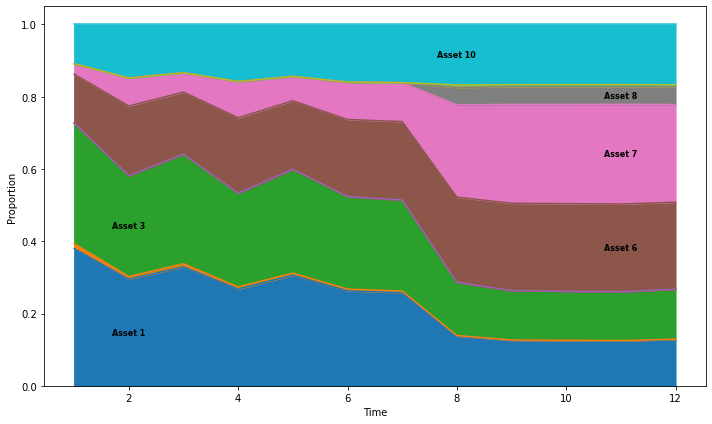

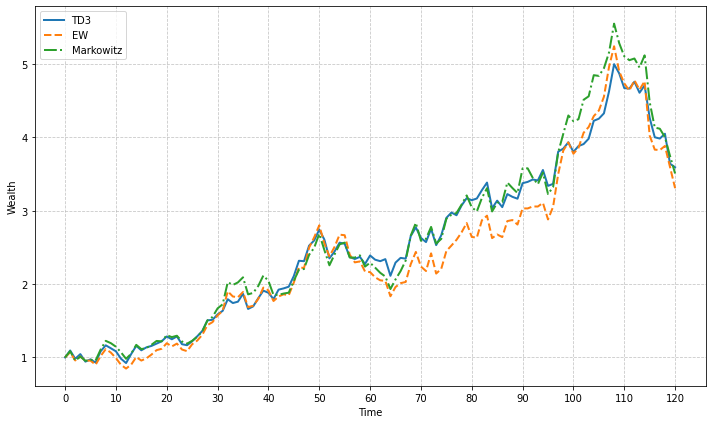

In [6]:
test_utils.plot_portfolio(portfolio_array[0, :time_horizon-1],time_horizon,num_assets)

wealth_data = {
        'TD3': wealth_list_td3,
        'EW' : wealth_list_ew,
        'Markowitz': wealth_list_mk
    }

test_utils.plot_wealth_trajectory(algo_list,wealth_data)